In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os, sys, gc
import pickle

import itertools
import seaborn as sns

os.chdir("/home/fvalle/phd/mouse_Atlas/")
sys.path.append("/home/fvalle/phd/")
sys.path.append("/home/fvalle/phd/master_thesis/")
from tableanalyser import discretize_df_columns, plotvarmen, plotcv2mean, plotoversigmacv2, getovergenes, plotoverpoints
from tacos_plot import scatterdense

In [2]:
# bash gunzip $(ls | grep -e "[a-zA-Z0-9\.\__].gz")
files = os.listdir('data')
rs = np.random.RandomState(seed=42)
rs.shuffle(files)

In [ ]:
def cleanup():
    os.chdir("data")
    for file in files:
        print(file)
        with open(file, "r") as f:
            data = f.read().replace("\"","")
        with open(file, "w") as f:
            f.write(data)
    os.chdir("../")

In [3]:
df_info = pd.read_csv("MCA_Figure2_Cell.info_V2.csv", index_col=0)
df_info['Cell_id'] = list(map(lambda ann: ann.replace("Adult",""), df_info['Cell_id'])) #remove adult or fetal
df_info['Cell_id'] = list(map(lambda ann: ann.replace("Fetal",""), df_info['Cell_id'])) #remove adult or fetal
df_info.head()

,Cell_barcode,Batch,Cell_id,Cluster_id,Development_stage,Method,Species,tissue,group,Celltype
1,AAAACGAAGCGGCCGCTA,AdultBladder1,Bladder_1.AAAACGAAGCGGCCGCTA,AdultBladder_5,Adult,Microwell-seq,Mouse,AdultBladder,30,Fibroblast
2,AAAACGAAGTACTAGCAT,AdultBladder1,Bladder_1.AAAACGAAGTACTAGCAT,AdultBladder_16,Adult,Microwell-seq,Mouse,AdultBladder,30,Fibroblast
3,AAAACGACGTTGCTGTGT,AdultBladder1,Bladder_1.AAAACGACGTTGCTGTGT,AdultBladder_8,Adult,Microwell-seq,Mouse,AdultBladder,30,Fibroblast
4,AAAACGAGCGAGCGAGTA,AdultBladder1,Bladder_1.AAAACGAGCGAGCGAGTA,AdultBladder_4,Adult,Microwell-seq,Mouse,AdultBladder,30,Fibroblast
5,AAAACGAGGGTCAGATGG,AdultBladder1,Bladder_1.AAAACGAGGGTCAGATGG,AdultBladder_7,Adult,Microwell-seq,Mouse,AdultBladder,30,Fibroblast


In [ ]:
#df_file=pd.read_csv("MCA_CellAssignments.csv", index_col=0).set_index('Cell.name')
#df_file['Cell_type'] = list(map(lambda ann: ann.split('(')[0].split(' ')[0], df_file['Annotation'])) #remove adult or fetal
#print(df_file.info())
#print(df_file['Tissue'].unique())
#print(df_file['Cell_type'].unique())
#df_file.head()

In [4]:
df_info.groupby(['Development_stage']).count()

,Cell_barcode,Batch,Cell_id,Cluster_id,Method,Species,tissue,group,Celltype
Development_stage,,,,,,,,,
Adult,45565,45565,45565,45565,45565,45565,45565,45565,45565
E14.5Embryos,1280,1280,1280,1280,1280,1280,1280,1280,1280
Fetal,16212,16212,16212,16212,16212,16212,16212,16212,16212
Neonatal,14220,14220,14220,14220,14220,14220,14220,14220,14220


In [5]:
df_info.groupby(['tissue','Celltype']).count()

Cell_barcode  Batch  Cell_id  \
tissue       Celltype                                                     
AdultBladder Cd8 T cell                              13     13       13   
             Dendritic cell                          39     39       39   
             Endothelial cell                        92     92       92   
             Fibroblast                             904    904      904   
             M2 Macrophage                           39     39       39   
...                                                 ...    ...      ...   
Uterus       Monocyte                                 7      7        7   
             Osteoblast                             387    387      387   
             Plasmacytoid dendritic cell              1      1        1   
             Smooth muscle cell                      21     21       21   
             Stromal cell                           829    829      829   

                                           Cluster_id  Development_stage  \
tissue       Celltype                                                      
AdultBladder Cd8 T cell                            13                 13   
             Dendritic cell                        39                 39   
             Endothelial cell                      92                 92   
             Fibroblast                           904                904   
             M2 Macrophage                         39                 39   
...                                               ...                ...   
Uterus       Monocyte                               7                  7   
             Osteoblast                           387                387   
             Plasmacytoid dendritic cell            1                  1   
             Smooth muscle cell                    21                 21   
             Stromal cell                         829                829   

                                           Method  Species  group  
tissue       Celltype                                              
AdultBladder Cd8 T cell                        13       13     13  
             Dendritic cell                    39       39     39  
             Endothelial cell                  92       92     92  
             Fibroblast                       904      904    904  
             M2 Macrophage                     39       39     39  
...                                           ...      ...    ...  
Uterus       Monocyte                           7        7      7  
             Osteoblast                       387      387    387  
             Plasmacytoid dendritic cell        1        1      1  
             Smooth muscle cell                21       21     21  
             Stromal cell                     829      829    829  

[609 rows x 8 columns]

In [6]:
def heaps(M, diffWords, tissue):
    if len(M) < 2:
        return
    fig = plt.figure(figsize=(10,6))
    plt.title(tissue)
    plt.scatter(M, diffWords, label='samples')
    #plt.scatter(M_null, diffWords_null, label='null_model')
    plt.xlabel("Realization size", fontsize=24)
    plt.ylabel("#different words", fontsize=24)
    skip_bins = 15
    n_bins=35
    bin_means, bin_edges, binnumber = stats.binned_statistic(M, diffWords,statistic='mean', bins=np.linspace(0,max(M), n_bins))
    plt.hlines(bin_means[:-skip_bins], bin_edges[:-1][:-skip_bins], bin_edges[1:][:-skip_bins], colors='r', lw=5, label='binned average')
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlim(0,max(M)*1.1)
    plt.legend(fontsize=20)
    plt.show()
    fig.savefig(f"heaps_{tissue}.png")

GSM2906469_SmallIntestine2_dge.txt
['SmallIntestine']


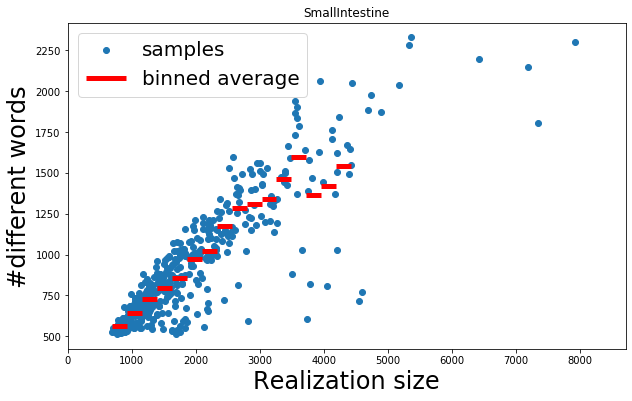

In [9]:
print(files[0])
data = pd.read_csv(f"data/{files[0]}", sep=" ")
data = data[data.columns[data.columns.isin(df_info['Cell_id'])]]

tissues = df_info[df_info['Cell_id'].isin(data.columns) & (df_info['Development_stage']=='Adult')]['tissue'].unique()
print(tissues)
for tissue in tissues:
    df = data.reindex(columns=df_info[df_info['Cell_id'].isin(data.columns) & (df_info['tissue']==tissue)]['Cell_id'])
    A = df.sum(axis=1)
    O = df.apply(lambda x: len(x[x>0]), 1)
    M = df.apply(np.sum, 0)
    frac_of = {}
    frac_of[tissue] = {'data': A,
                            'N': len(M)}
    diffWords = df.apply(lambda x: len(x[x!=0]), 0)
    means = df.apply(np.average, 1)
    means_nozero = df.apply(lambda x: x[x>0].mean(), 1)
    var = df.apply(np.var, 1)
    n_expressed_genes = pd.Series(index=df.index, data=np.zeros_like(df.index))
    n_expressed_genes[A.sort_values(ascending=False).index[:100]]+=1
    heaps(M, diffWords, tissue)

In [ ]:
for file in files[1:]:
    print(file)
    data = pd.read_csv(f"data/{file}", sep=" ")
    data = data[data.columns[data.columns.isin(df_info['Cell_id'])]]
    
    if len(data.columns) < 1:
        print(f"skipping {file} \n")
        continue
    
    tissues = df_info[df_info['Cell_id'].isin(data.columns) & (df_info['Development_stage']=='Adult')]['tissue'].unique()

    print(tissues)
    if len(tissues) < 1:
        print(f"no tissue found \n")
        continue
    for tissue in tissues:
        df = data.reindex(columns=df_info[df_info['Cell_id'].isin(data.columns) & (df_info['tissue']==tissue)]['Cell_id'])
        A_sub = df.sum(axis=1)
        O_sub = df.apply(lambda x: len(x[x>0]), 1)
        M_sub = df.apply(np.sum, 0)
        diffWords_sub = df.apply(lambda x: len(x[x!=0]), 0)
        means_sub = df.apply(np.average, 1)
        means_nozero_sub = df.apply(lambda x: x[x>0].mean(), 1)
        var_sub = df.apply(np.var, 1)

        if tissue in frac_of.keys():
            frac_of[tissue]['data'].add(A_sub, fill_value = 0)
            frac_of[tissue]['N']+=len(M_sub)
        else:
            frac_of[tissue] = {'data': A_sub,
                                  'N': len(M_sub)}

        A = A.add(A_sub, fill_value=0)
        O_sub = O.add(O_sub, fill_value=0)
        M = M.append(M_sub)
        diffWords = diffWords.append(diffWords_sub)
        means = ((means * len(M)) + (means_sub * len(M_sub)))/(len(M) + len (M_sub))
        means_nozero = ((means_nozero * len(M)) + (means_nozero_sub * len(M_sub)))/(len(M) + len (M_sub))
        var = ((var * len(M)) + (var_sub * len(M_sub)))/(len(M) + len (M_sub))
        n_expressed_genes = n_expressed_genes.reindex_like(A_sub).fillna(0)
        n_expressed_genes[A_sub.sort_values(ascending=False).index[:100]]+=1

        print(f"Handling {len(M)} cells")

        del df 
        del A_sub
        del O_sub
        del M_sub
        del diffWords_sub
        del means_sub
        del means_nozero_sub
        del var_sub
        gc.collect()
        print("\n")
    del tissues
    del data
    gc.collect()

f = (A/A.sum())
O = O / len(M)
O = O.reindex_like(means)
cv2 = var/means/means

GSM2906415_FetalBrain_dge.txt
skipping GSM2906415_FetalBrain_dge.txt 

GSM2906462_PeripheralBlood4_dge.txt
['PeripheralBlood']
Handling 476 cells


GSM2906480_mouse-3T3_dge.txt
skipping GSM2906480_mouse-3T3_dge.txt 

GSM2906457_Ovary2_dge.txt
['Ovary']
Handling 1161 cells


GSM2906444_Muscle_dge.txt
['Muscle']
Handling 2263 cells


GSM2906433_MammaryGland.Involution.CD45.2_dge.txt
skipping GSM2906433_MammaryGland.Involution.CD45.2_dge.txt 

GSM2906449_NeonatalMuscle2_dge.txt
[]
no tissue found 

GSM2906466_PlacentaE14.2_dge.txt
[]
no tissue found 

GSM2906455_NeonatalBrain2_dge.txt
[]
no tissue found 

GSM2906479_Uterus2_dge.txt
['Uterus']
Handling 2957 cells


GSM2935549_EmbryonicStemCell.CJ7_Deep_dge.txt
skipping GSM2935549_EmbryonicStemCell.CJ7_Deep_dge.txt 

GSM2906453_NeonatalSkin_dge.txt
[]
no tissue found 

GSM2906474_Testis2_dge.txt
['Testis']
Handling 4485 cells


GSM2906463_PeripheralBlood5_dge.txt
['PeripheralBlood']
Handling 4552 cells


GSM2906418_FetalKidney1_dge.txt
skip

In [ ]:
data = {
    'means': means,
    'var': var,
    'freq': f,
    'O': O,
    'cv2': cv2,
    'diffWords': diffWords,
    'means_nonzero': means_nozero,
    'n_expressed': n_expressed_genes,
    'frac_of': frac_of
}

with open("data.pkl","wb") as file:
    pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("data.pkl","rb") as file:
    data = pickle.load(file)

means = data['means']
var = data['var']
f = data['freq']
O = data['O']
cv2 = data['cv2']
diffWords = data['diffWords']
means_nozero = data['means_nonzero']
n_expressed_genes = data['n_expressed']
frac_of = data['frac_of']

In [ ]:
#A = df.sum(axis=1)
#f = A/A.sum()
#O=O/len(M)
#O = df.apply(lambda x: len(x[x>0])/float(len(x)), 1)
#M = df.apply(np.sum, 0)
#diffWords = df.apply(lambda x: len(x[x!=0]), 0)
#means = df.apply(np.average, 1)
#var = df.apply(np.var, 1)
#cv2 = var/means/means

In [ ]:
list(map(print,n_expressed_genes[n_expressed_genes>=2].sort_values(ascending=False).index[:100]))

# Fraction of trascriptome

In [ ]:
palette = itertools.cycle(sns.color_palette(palette="Set1", n_colors=100, desat=.9))

thresholded = {}

fig,ax = plt.subplots(figsize=(15,8))
for tissue in frac_of.keys():
    A_tissue = (frac_of[tissue]['data'] / frac_of[tissue]['N']).sort_values(ascending=False)
    A_tissue = np.cumsum(A_tissue.values) / A_tissue.sum()
    ax.plot(A_tissue, label = tissue, c=next(palette))
    thresholded[tissue] = np.argwhere(A_tissue>=0.5).ravel()[0]
ax.set_xscale('log')
ax.set_xlim(1, 3e4)
ax.tick_params(labelsize=20)
ax.set_xlabel("Number of genes", fontsize=24)
ax.set_ylabel("Fraction of trascriptome\n described", fontsize=24)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
gene_to_thr = pd.DataFrame(data= thresholded.items()).set_index(0).sort_values(1)

fig,ax = plt.subplots(figsize=(20,4))
ax.bar(gene_to_thr.index, gene_to_thr.values.ravel())
ax.tick_params(rotation=90)
plt.show()

# Null Model

In [ ]:
#%%timeit
rs = np.random.RandomState(seed=42)
df_null = pd.DataFrame(index=f.index)
for sample in M.index:
    if sample in df_null.columns:
        continue
    df_null.insert(0,sample,np.average(np.array([rs.multinomial(M[sample], f.astype(float).values/f.sum()) for _ in range(5)]), axis=0))
    gc.collect()
#df_null=df_null.astype(int)
gc.collect()

In [ ]:
A_null = df_null.mean(axis=1)
f_null = A_null/A_null.sum()
O_null = df_null.apply(lambda x: len(x[x>0])/float(len(x)), 1)
M_null = df_null.apply(np.sum, 0)
diffWords_null = df_null.apply(lambda x: len(x[x!=0]), 0)
means_null = df_null.apply(np.average, 1)
var_null = df_null.apply(np.var, 1)
cv2_null = var_null/means_null/means_null

# Zipf

In [ ]:
fig = plt.figure(figsize=(10,8))
x = np.arange(1, len(f))
plt.ylabel("$Frequency, f_i$", fontsize=24)
plt.xlabel("$RANK, i$", fontsize=24)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-7,1)
plt.plot(x, 1./x, 'g--', lw=2, label='$i^{-1}$')
plt.plot(np.sort(f.dropna())[::-1], c='blue', lw=5, label='Genes')
#plt.plot(np.sort(f_null/f_null.sum())[::-1], c='orange', ls='--', lw=5, label='null_model')
plt.legend(fontsize=24)
plt.show()
fig.savefig("zipf.png")

In [ ]:
bins = 100
rang = (0-0.5/bins, 1+0.5/bins)
fig=plt.figure()
plt.hist(np.array(O.dropna(), dtype=float), histtype='step', lw=5, range = rang, color='blue', density=True, bins=bins)
#plt.hist(np.array(O_null, dtype=float), histtype='step', lw=5, range = rang, color='orange', ls='--', density=True)
plt.xlabel("$o_i$", fontsize=24)
plt.ylabel("pdf", fontsize=24)
plt.yscale('log')
#plt.xscale('log')
plt.show()
fig.savefig("U.png")

In [ ]:
fig = plt.figure()
plt.hist(M, density=False, color='blue', bins = 15, label='files')
#plt.hist(M_null, density=False, color='orange', histtype='step', lw=4, ls='--', bins = 15, label='files')
plt.title("realization size distribution", fontsize = 24)
plt.xlabel("total counts per file", fontsize=24)
plt.ylabel("#", fontsize=24)
plt.legend(fontsize=24)
plt.show()
fig.savefig("M_distr.png")

In [ ]:
fig = plt.figure()
plt.hist(diffWords, density=False, color='blue', bins = 15, label = 'files')
plt.title("vocabulary size distribution", fontsize=18)
plt.xlabel("#different words per file", fontsize=16)
plt.ylabel("#", fontsize=16)
plt.legend(fontsize=18)
plt.show()
fig.savefig("gene_expr_distr.png")

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.scatter(M, diffWords, label='samples')
#plt.scatter(M_null, diffWords_null, label='null_model')
plt.xlabel("Realization size", fontsize=24)
plt.ylabel("#different words", fontsize=24)
skip_bins = 15
n_bins=35
bin_means, bin_edges, binnumber = stats.binned_statistic(M, diffWords,statistic='mean', bins=np.linspace(0,max(M), n_bins))
plt.hlines(bin_means[:-skip_bins], bin_edges[:-1][:-skip_bins], bin_edges[1:][:-skip_bins], colors='r', lw=5, label='binned average')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,max(M)*1.1)
plt.legend(fontsize=20)
plt.show()
fig.savefig("heaps.png")

In [ ]:
bin_std, bin_edges, binnumber = stats.binned_statistic(M, diffWords,statistic='std', bins=np.linspace(0,max(M), n_bins))
bin_vars = bin_std*bin_std
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(bin_means[:-skip_bins], bin_vars[:-skip_bins],s=90, label='')
ax.plot(bin_means[:-skip_bins], bin_means[:-skip_bins], label='Poisson')
ax.plot(bin_means[:-skip_bins], bin_means[:-skip_bins]**2, label='Taylor')
ax.set_xlabel("Heaps' mean", fontsize=24)
ax.set_ylabel("Heaps' var", fontsize=24)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=24)
#ax.set_ylim(1e3,3e4)
ax.set_xlim(np.nanmin(bin_means),np.nanmax(bin_means))
plt.show()
fig.savefig("heaps_Taylor.png")

# CV2

In [ ]:
means = means.dropna()
var = var.reindex_like(means)
O = O.reindex_like(means)

In [ ]:
fig, ax =plt.subplots(figsize=(15,8))
plotcv2mean(means.values, var.values, ax=ax, normalisation_str='counts')
fig.savefig("cvmean_loglog.png")

# Mean vs Occurrence

In [ ]:
fig=plt.figure(figsize=(8,5))
nfiles = len(M)
plt.scatter(O*nfiles, means, c='b', alpha=0.8, label='genes')
#plt.scatter(O_null*len(M_null), means_null*5, c='orange', alpha=0.8, label='genes')
plt.plot(np.linspace(1,nfiles), np.linspace(1,nfiles)/(nfiles), lw=4, label='bound', c='cyan', ls='--')
bin_means, bin_edges, _ = stats.binned_statistic(O*nfiles, means, statistic='mean', bins=np.logspace(-3,6))
x = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(x,bin_means, marker='x', c='r', label='binned average')
plt.ylabel("$<counts>$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(counts)$", fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(means[means!=0].min()/5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+800)
plt.legend(fontsize=20)
plt.show()
fig.savefig("mean_occ.png")

In [ ]:
fig=plt.figure(figsize=(8,5))
nfiles = len(M)
plt.scatter(O.reindex_like(means_nozero)*nfiles, means_nozero, c='b', alpha=0.8, label='genes')
#bin_means, bin_edges, _ = stats.binned_statistic(O.reindex_like(means_nozero)*nfiles, means_nozero, statistic='mean', bins=np.linspace(1,1e4,200))
#x = (bin_edges[1:]+bin_edges[:-1])/2
#plt.scatter(x,bin_means, marker='x', c='r', label='binned average')
plt.ylabel("$<counts(>0)>$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(counts)$", fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.9,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+800)
plt.legend(fontsize=20)
plt.show()
fig.savefig("mean_occ_non_zero.png")

# Null model 1

In [ ]:
#%%timeit
rs = np.random.RandomState(seed=42)
df_null_1 = pd.DataFrame(index=f.index)
df[sample]
for sample in M.index:
    df_null_1.insert(0,sample,np.average(np.array([rs.multinomial(M[sample], df[sample].astype(float).values/df[sample].sum()) for _ in range(1)]), axis=0))
#df_null=df_null.astype(int)

In [ ]:
A_null_1 = df_null_1.mean(axis=1)
f_null_1 = A_null_1/A_null_1.sum()
O_null_1 = df_null_1.apply(lambda x: len(x[x>0])/float(len(x)), 1)
M_null_1 = df_null_1.apply(np.sum, 0)
diffWords_null_1 = df_null_1.apply(lambda x: len(x[x!=0]), 0)
means_null_1 = df_null_1.apply(np.average, 1)
var_null_1 = df_null_1.apply(np.var, 1)
cv2_null_1 = var_null_1/means_null_1/means_null_1

In [ ]:
fig = plt.figure(figsize=(10,8))
x = np.arange(1, len(f))
plt.ylabel("$Frequency, f_i$", fontsize=24)
plt.xlabel("$RANK, i$", fontsize=24)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-7,1)
plt.plot(x, 1./x, 'g--', lw=2, label='$i^{-1}$')
plt.plot(np.sort(f/f.sum())[::-1], c='blue', lw=8, label='Genes')
plt.plot(np.sort(f_null/f_null.sum())[::-1], c='orange', ls='--', lw=6, label='null_model')
plt.plot(np.sort(f_null_1/f_null_1.sum())[::-1], c='green', ls=':', lw=5, label='null_model_1')
plt.legend(fontsize=24)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.scatter(M, diffWords, label='samples')
plt.scatter(M_null, diffWords_null, label='null_model')
plt.scatter(M_null_1, diffWords_null_1, label='null_model_1')
plt.xlabel("Realization size", fontsize=24)
plt.ylabel("#different words", fontsize=24)
bin_means, bin_edges, binnumber = stats.binned_statistic(M, diffWords,statistic='mean', bins=np.linspace(0,max(M)))
plt.hlines(bin_means[:-15], bin_edges[:-1][:-15], bin_edges[1:][:-15], colors='r', lw=5, label='binned average')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,max(M)*1.1)
plt.legend(fontsize=20)
plt.show()

In [ ]:
fig, ax =plt.subplots(figsize=(15,8))
ax.scatter(means_null, cv2_null, c='orange')
ax.scatter(means_null_1, cv2_null_1, c='green')
plotcv2mean(means.values, var.values, ax=ax, normalisation_str='counts')
fig.savefig("cvmean_loglog.png")